In [2]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Load the dataset
file_path = 'Target Response DB.csv'
df = pd.read_csv(file_path)

# Encode the responses
response_columns = ['Question 7', 'Question 8', 'Question 9', 'Question 10', 'Question 11']
df_encoded = df.copy()

# Encoding A, B, C, D to 0, 1, 2, 3
response_mapping = {'A': 0, 'B': 1, 'C': 2, 'D': 3}
reverse_mapping = {v: k for k, v in response_mapping.items()}
for col in response_columns:
    df_encoded[col] = df_encoded[col].map(response_mapping)

# Split data into features and labels
X = df_encoded['Job description']
y = df_encoded[response_columns]

# Text Preprocessing and Vectorization
vectorizer = TfidfVectorizer(ngram_range=(1, 2), stop_words='english')  # Using bigrams and removing stop words
X_vectorized = vectorizer.fit_transform(X)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_vectorized, y, test_size=0.2, random_state=42)

# Define the model
base_model = GradientBoostingClassifier(random_state=42)

# Define the hyperparameters grid
param_grid = {
    'estimator__n_estimators': [50, 100],
    'estimator__learning_rate': [0.05, 0.1],
    'estimator__max_depth': [3, 5]
}

# Initialize Grid Search
grid_search = GridSearchCV(MultiOutputClassifier(base_model), param_grid, cv=3, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Best model from grid search
best_model = grid_search.best_estimator_

# Predict on the test set
y_pred = best_model.predict(X_test)

# Convert predictions to DataFrame for easy manipulation
predictions = pd.DataFrame(y_pred, columns=response_columns)
for col in response_columns:
    predictions[col] = predictions[col].map(reverse_mapping)

# Initialize metric dictionaries
metrics = {
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1': []
}

# Calculate evaluation metrics for each question
for i, col in enumerate(response_columns):
    y_test_col = y_test[col].map(reverse_mapping)
    metrics['accuracy'].append(accuracy_score(y_test_col, predictions[col]))
    metrics['precision'].append(precision_score(y_test_col, predictions[col], average='macro', zero_division=1))
    metrics['recall'].append(recall_score(y_test_col, predictions[col], average='macro', zero_division=1))
    metrics['f1'].append(f1_score(y_test_col, predictions[col], average='macro', zero_division=1))

# Average the metrics across all questions
avg_metrics = {metric: sum(values) / len(values) for metric, values in metrics.items()}

def adjust_predictions(predictions):
    for index, row in predictions.iterrows():
        main_focus_found = False
        for col in reversed(predictions.columns):
            if main_focus_found:
                # Mark all preceding questions as 'D'
                predictions.at[index, col] = 'D'
            if row[col] == 'A':
                main_focus_found = True
    return predictions

# Adjust predictions based on the rule
adjusted_predictions = adjust_predictions(predictions.copy())

# Example prediction
new_description = ["To provide of an effective Joinery resource to ensure the University fabric is efficiently maintained..."]
new_description_vectorized = vectorizer.transform(new_description)
predictions_new = best_model.predict(new_description_vectorized)

# Decode the predictions
predictions_new_df = pd.DataFrame(predictions_new, columns=response_columns)
for col in response_columns:
    predictions_new_df[col] = predictions_new_df[col].map(reverse_mapping)

# Adjust the new predictions
adjusted_predictions_new = adjust_predictions(predictions_new_df.copy())

# Print the job description and its predicted responses
print("Job Description:", new_description[0])
print("Predicted Responses:", adjusted_predictions_new.iloc[0].to_dict())

# Print evaluation metrics
print(f"Accuracy: {avg_metrics['accuracy']:.4f}")
print(f"Precision: {avg_metrics['precision']:.4f}")
print(f"Recall: {avg_metrics['recall']:.4f}")
print(f"F1 Score: {avg_metrics['f1']:.4f}")


c:\Users\nosao\anaconda3\Lib\site-packages\sklearn\model_selection\_search.py:952: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan]
  warnings.warn(


Job Description: To provide of an effective Joinery resource to ensure the University fabric is efficiently maintained...
Predicted Responses: {'Question 7': 'B', 'Question 8': 'C', 'Question 9': 'D', 'Question 10': 'B', 'Question 11': 'B'}
Accuracy: 0.6333
Precision: 0.6434
Recall: 0.6146
F1 Score: 0.5297


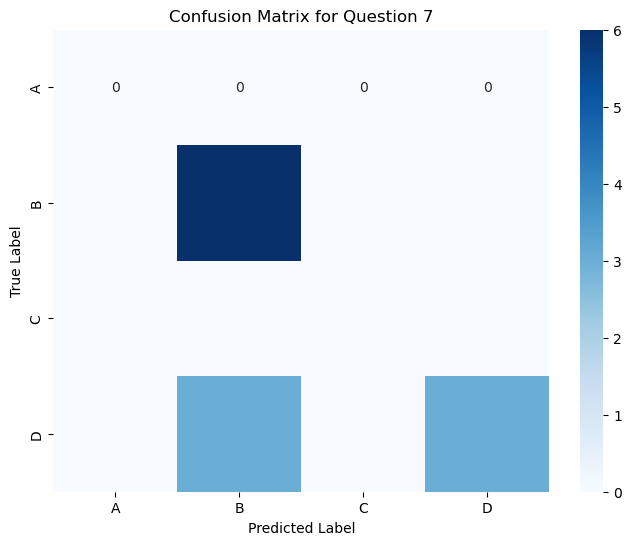

In [3]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Example for 'Question 7'
y_test_q7 = y_test['Question 7'].map(reverse_mapping)
y_pred_q7 = predictions['Question 7']

# Generate confusion matrix
cm_q7 = confusion_matrix(y_test_q7, y_pred_q7, labels=['A', 'B', 'C', 'D'])

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_q7, annot=True, fmt='d', cmap='Blues', xticklabels=['A', 'B', 'C', 'D'], yticklabels=['A', 'B', 'C', 'D'])
plt.title('Confusion Matrix for Question 7')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


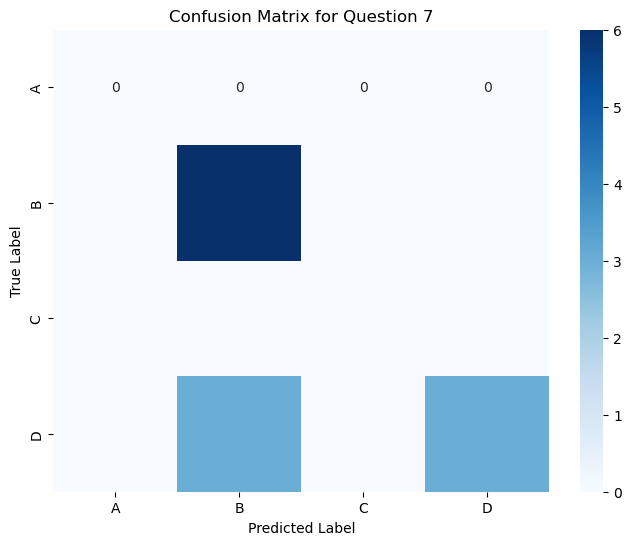

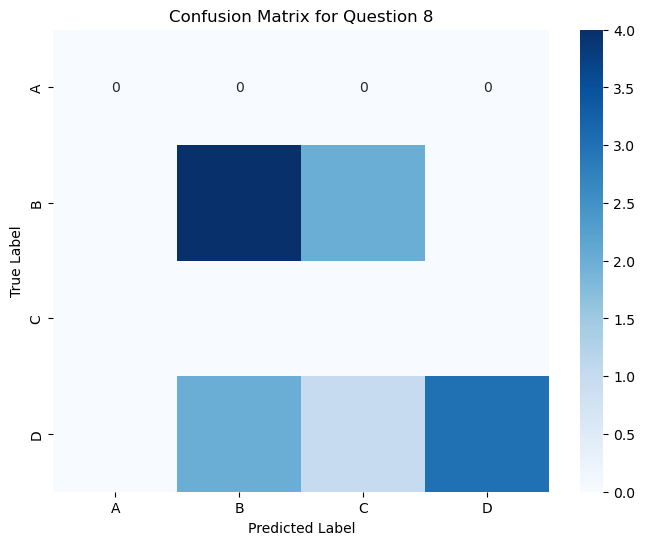

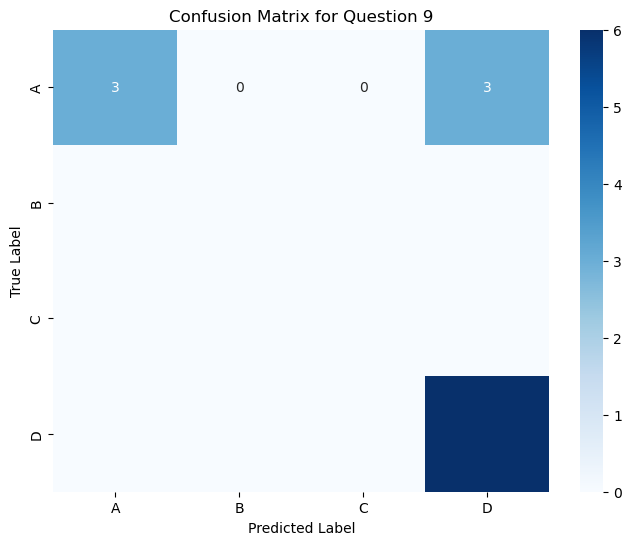

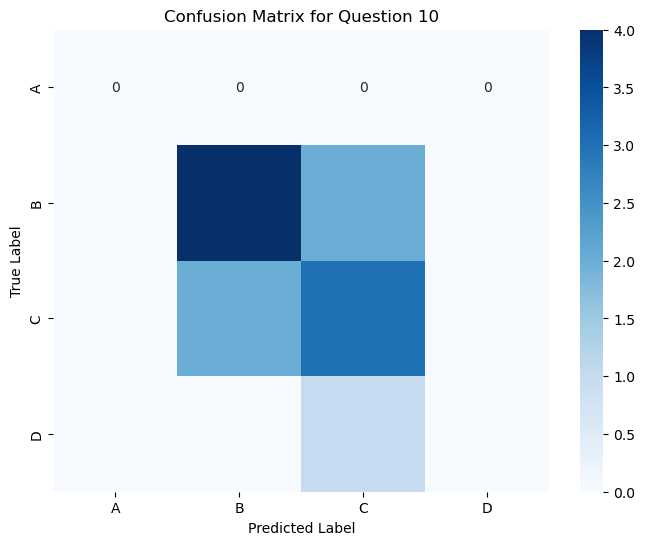

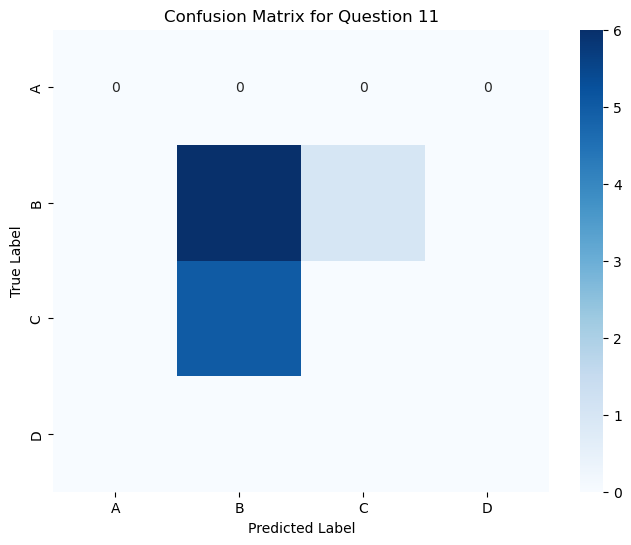

In [4]:
for question in response_columns:
    y_test_col = y_test[question].map(reverse_mapping)
    y_pred_col = predictions[question]
    
    cm = confusion_matrix(y_test_col, y_pred_col, labels=['A', 'B', 'C', 'D'])
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['A', 'B', 'C', 'D'], yticklabels=['A', 'B', 'C', 'D'])
    plt.title(f'Confusion Matrix for {question}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()


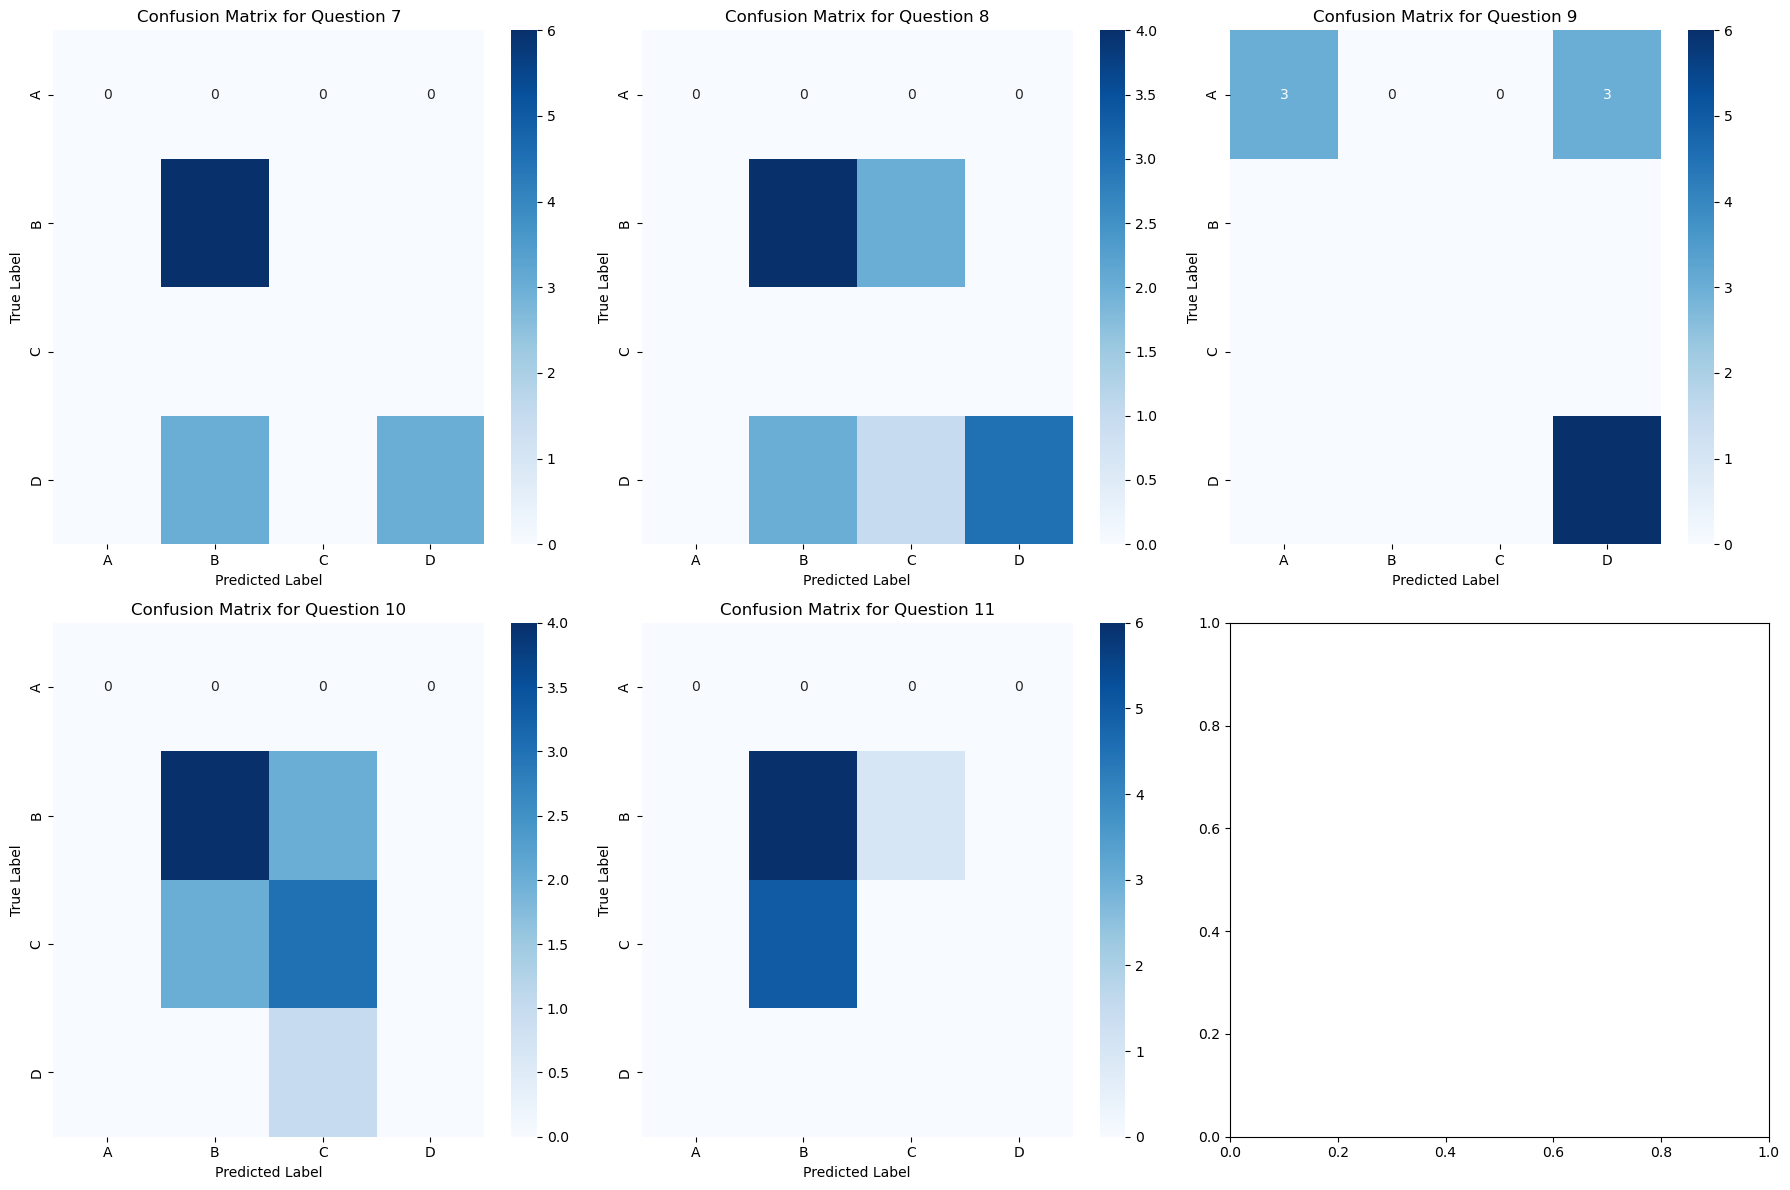

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Set up a grid of subplots
fig, axes = plt.subplots(2, 3
, figsize=(18, 12))
axes = axes.flatten()

# Iterate through each question and plot its confusion matrix in a subplot
for i, question in enumerate(response_columns):
    y_test_col = y_test[question].map(reverse_mapping)
    y_pred_col = predictions[question]
    
    # Compute the confusion matrix
    cm = confusion_matrix(y_test_col, y_pred_col, labels=['A', 'B', 'C', 'D'])
    
    # Plot the confusion matrix in a subplot
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i],
                xticklabels=['A', 'B', 'C', 'D'], yticklabels=['A', 'B', 'C', 'D'])
    axes[i].set_title(f'Confusion Matrix for {question}')
    axes[i].set_xlabel('Predicted Label')
    axes[i].set_ylabel('True Label')

# Adjust layout
plt.tight_layout()
plt.show()


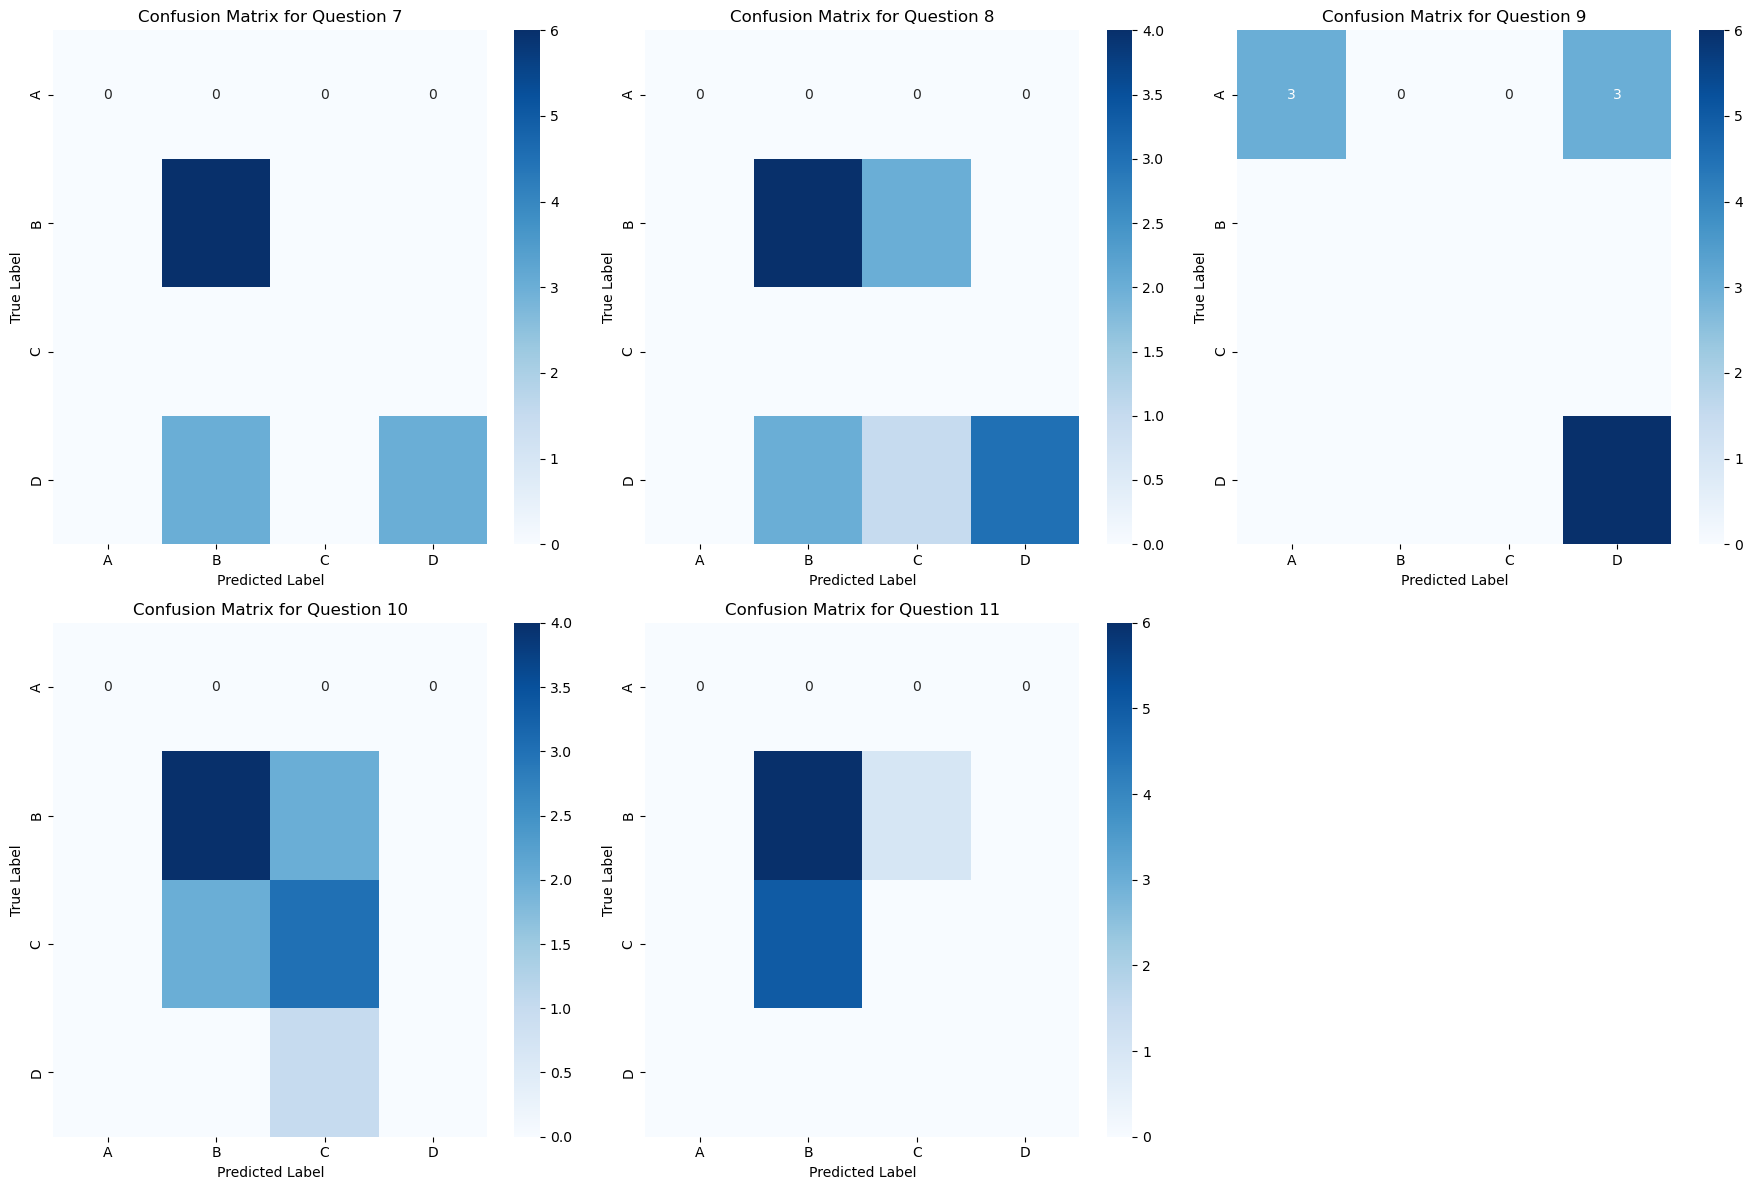

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Set up a grid of subplots with 2 rows and 3 columns
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

# Iterate through each question and plot its confusion matrix in a subplot
for i, question in enumerate(response_columns):
    y_test_col = y_test[question].map(reverse_mapping)
    y_pred_col = predictions[question]
    
    # Compute the confusion matrix
    cm = confusion_matrix(y_test_col, y_pred_col, labels=['A', 'B', 'C', 'D'])
    
    # Plot the confusion matrix in a subplot
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i],
                xticklabels=['A', 'B', 'C', 'D'], yticklabels=['A', 'B', 'C', 'D'])
    axes[i].set_title(f'Confusion Matrix for {question}')
    axes[i].set_xlabel('Predicted Label')
    axes[i].set_ylabel('True Label')

# Remove the empty subplot
fig.delaxes(axes[-1])

# Adjust layout
plt.tight_layout()
plt.show()
